🚀 Starting Generalization Test on CIC-IDS2017...
📂 Loading file: ../data/raw/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
✅ Data loaded successfully. Initial Shape: (225745, 79)

🧹 Cleaning dataset...
   - Removed 34 rows with NaN/Infinity.
   - Classes found: ['BENIGN', 'DDoS']
   - Selected 78 numeric features for training.

⚖️ Preparing Data Splits...
   - Original Train Distribution: [ 78148 102420]
   - Applying SMOTE...
✅ SMOTE Complete. New Train Distribution: [102420 102420]

🌲 Training Random Forest Classifier...
✅ Training complete.

📊 EVALUATION RESULTS (CIC-IDS2017)
🏆 TEST ACCURACY: 99.9911%

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19538
        DDoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



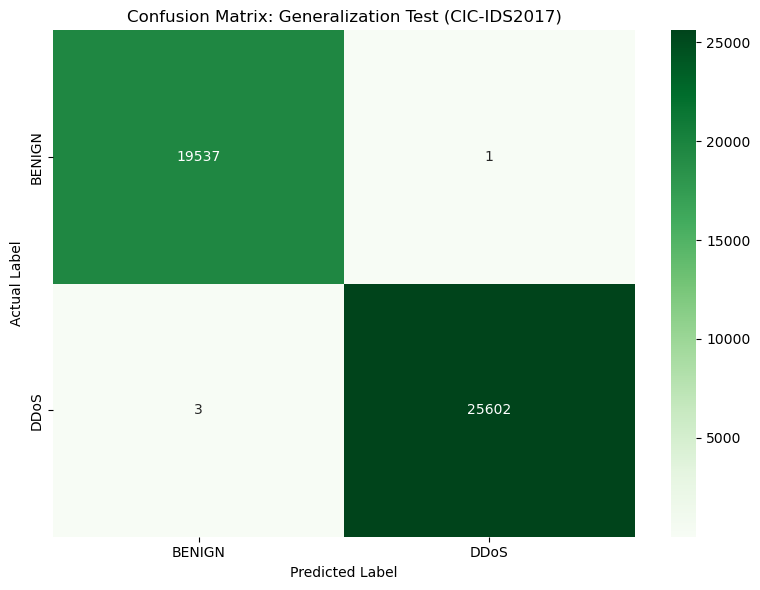


✅ TEST COMPLETED SUCCESSFULLY.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# We use the 'Friday-WorkingHours-Afternoon-DDos' file because it contains 
# a balanced mix of BENIGN and DDoS traffic, ideal for validation.
FILE_PATH = "../data/raw/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

print(f"🚀 Starting Generalization Test on CIC-IDS2017...")
print(f"📂 Loading file: {FILE_PATH}")

try:
    df = pd.read_csv(FILE_PATH)
    print(f"✅ Data loaded successfully. Initial Shape: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please check the path.")
    raise

# ==============================================================================
# 1. CLEANING & PREPROCESSING
# ==============================================================================
print("\n🧹 Cleaning dataset...")

# Strip whitespace from column names (Common issue in CIC datasets)
df.columns = df.columns.str.strip()

# Handle Infinite and NaN values
original_rows = len(df)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"   - Removed {original_rows - len(df)} rows with NaN/Infinity.")

# Identify Target Column
target_col = 'Label'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found.")

# Encode Labels (BENIGN vs DDoS)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print(f"   - Classes found: {list(le.classes_)}")

# Feature Selection: Keep only numeric columns
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_cols = X.select_dtypes(include=[np.number]).columns
X = X[numeric_cols]
print(f"   - Selected {len(numeric_cols)} numeric features for training.")

# Scaling (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==============================================================================
# 2. SPLIT & SMOTE
# ==============================================================================
print("\n⚖️ Preparing Data Splits...")

# Stratified Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE (Applied only to Training Data)
print(f"   - Original Train Distribution: {np.bincount(y_train)}")
print("   - Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"✅ SMOTE Complete. New Train Distribution: {np.bincount(y_train_res)}")

# ==============================================================================
# 3. ARCHITECTURE VALIDATION (Random Forest)
# ==============================================================================
print("\n🌲 Training Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_res, y_train_res)
print("✅ Training complete.")

# ==============================================================================
# 4. EVALUATION & REPORTING
# ==============================================================================
print("\n📊 EVALUATION RESULTS (CIC-IDS2017)")
print("="*60)

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"🏆 TEST ACCURACY: {acc:.4%}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: Generalization Test (CIC-IDS2017)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n✅ TEST COMPLETED SUCCESSFULLY.")